## 참고사이트
https://hannibunny.github.io/mlbook/transformer/intent_classification_with_bert.html

#### BERT의 핵심 아이디어 : 대량의 단어 Corpus로 양방향으로(Bidireictional) 
- 학습시킨 Pre-Trained 자연어 처리 모델을 제공하고, 마지막 레이어에 간단한 
- ANN 등의 추가만을 통한 Fine-Tuning을 이용해서 다양한 자연어처리 Task에 대해서 state-of-the-art 성능을 보여줄 수 있음

# 8. BERT로 텍스트 분류 - 한글

- Naver 영화 리뷰 데이터 세트에 대한 감정 분석을 수행하기 위해 텍스트를 적절한 형식으로 사전 처리하는 방법-  - BERT를 Fine Tuning하는 완전한 코드가 포함되어 있습니다.

수행할 작업은 다음과 같습니다.

1. 데이터셋 불러오기
2. TensorFlow Hub에서 BERT 모델 로드
3. BERT와 분류기를 결합하여 나만의 모델 구축
4. BERT를 미세 조정하여 자신만의 모델을 훈련
5. 모델을 저장하고 문장 분류에 사용

In [1]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 41.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic 2.2.1 requires typing-extensions>=4.6.1, but you have typing-extensions 4.5.0 which is incompatible.
pydantic-core 2.6.1 requires typing-extensions!=4.7.0,>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) .

In [2]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd

## Sentiment analysis

리뷰 텍스트를 기반으로 영화 리뷰를 *긍정* 또는 *부정*으로 분류합니다.

### naver movie dataset Download


In [35]:
DATA_TRAIN_PATH = '/content/ratings_train.txt'
DATA_TEST_PATH = '/content/ratings_test.txt'

In [36]:
train_data = pd.read_csv(DATA_TRAIN_PATH, delimiter='\t')
test_data = pd.read_csv(DATA_TEST_PATH, delimiter='\t')
print(train_data.shape)
print(test_data.shape)


(150000, 3)
(50000, 3)


train 시간 단축을 위해 데이터의 1/10 만 사용

In [5]:
train_data = train_data.sample(n=15000, random_state=1)
test_data = test_data.sample(n=5000, random_state=1)

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

print(train_data.shape)
print(test_data.shape)

train_data.head(3)

(14998, 3)
(5000, 3)


,id,document,label
58397,10040150,그런 여성은 21세기 잘 나가는 커리어 우먼으로 살아야 하는 타입이다. 시대와 맞지...,1
108538,9972114,왜 봤는지 모를 정말 재미없는 졸작 별하나도 아까움,0
149880,5627263,순수함에서 나온 커다란 감동과 아름다움을 준 따뜻한 영화. 오랜만에 목이 메였다.,1


In [6]:
class_names = {1: '긍정', 0: '부정'}

In [7]:
AUTOTUNE = tf.data.AUTOTUNE   #자동으로 GPU 성능 최적화
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_data['document'], train_data['label']))
train_ds = train_ds.batch(batch_size).shuffle(10000).cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_data['document'], test_data['label']))
test_ds = test_ds.batch(batch_size).shuffle(10000).cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(6):
    print(f'영화평: {text_batch.numpy()[i].decode("utf-8")}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

영화평: 쎼뇨리따 김!!! 시즌 2 갑시다!!
Label : 1 (긍정)
영화평: 내가 만들어도 이보단 잘 만들 자신있다!!
Label : 0 (부정)
영화평: 2006년도 군휴가나와서 본영화..기대안하고 보았는데 최고였던 영화
Label : 1 (긍정)
영화평: 헐ㅈㅎ다맘ㅇ든다
Label : 1 (긍정)
영화평: 저 개인적으로 매드맥스보다 약간 좋다고 생각하네요! 매드맥스는 약간 시끄러우면서 뭔가 좀.. 그런데..이 영화는 코믹,인생등 너무 많을 걸 담았네요! 대단합니다!
Label : 1 (긍정)
영화평: 청년 창업의 명과암....
Label : 1 (긍정)


## TensorFlow Hub에서 모델 로드

TensorFlow Hub에서 로드하고 미세 조정할 여러 BERT 모델을 선택할 수 있습니다.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/ 3) 원래 BERT 작성자가 발표한 가중치
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1): 동일한 일반 아키텍처를 갖지만 더 적거나 더 작은 Transformer 블록을 사용하므로 속도, 크기 및 품질 간의 균형을 모색.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): 레이어 간에 매개변수를 공유하여 모델 크기(하지만 계산 시간은 아님)를 줄이는 4가지 크기의 "A Lite BERT".
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): 모두 BERT 기반 아키텍처를 가지고 있지만 모델 목표 task 에 더 밀접하게 정렬하기 위해 8가지  서로 다른 사전 교육 도메인의 data 로 pre-train.
  - [Electra](https://tfhub.dev/google/collections/electra/1)는 BERT와 동일한 아키텍처(세 가지 다른 크기)를 갖지만 유사한 설정에서 생성적 적대 네트워크(GAN) 비슷한 discriminator로 사전 훈련.
  - Talking-Heads Attention 및 Gated GELU가 있는 BERT [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)]는 Transformer 아키텍처의 핵심에 대한 두 가지 개선 사항을 가집니다.

미세 조정 속도를 빠르게 하기위해 Small BERT(더 적은 수의 매개변수 사용)로 시작합 니다. 작지만 더 높은 정확도를 원한다면 ALBERT가 다음 옵션이 될 수 있습니다. 더 나은 정확도를 원하면 클래식 BERT 크기 중 하나를 선택하거나 Electra, Talking Heads 또는 BERT Expert와 같은 최근 개선 사항 중 하나를 선택합니다.

아래에서 사용 가능한 모델 외에도 더 크고 더 나은 정확도를 얻을 수 있는 모델의 [여러 버전](https://tfhub.dev/google/collections/transformer_encoders_text/1)이 있지만  단일 GPU에서 fine-tuning 하기에 너무 큽니다. [TPU colab에서 BERT를 사용하여 GLUE 작업 해결](https://www.tensorflow.org/text/tutorials/bert_glue)에서 이 작업을 수행할 수 있습니다.

In [9]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


## The preprocessing model

- 텍스트 입력은 BERT에 입력되기 전에 숫자 토큰 ID로 변환되고 여러 Tensor에 정렬되어야 합니다.   

- TensorFlow Hub는 위에서 설명한 각 BERT 모델에 대해 일치하는 전처리 모델을 제공하며, 이는 TF.text 라이브러리의(tensorflow_text) TF 작업을 사용하여 이 변환을 구현합니다. 텍스트를 사전 처리하기 위해 TensorFlow 모델 외부에서 순수 Python 코드를 실행할 필요는 없습니다.

- 전처리 모델은 위에 인쇄된 URL에서 읽을 수 있는 BERT 모델 문서에서 참조하는 모델이어야 합니다. 위의 드롭다운에서 BERT 모델의 경우 전처리 모델이 자동으로 선택됩니다.

In [10]:
tfhub_handle_preprocess, tfhub_handle_encoder

('https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3')

hub.KerasLayer()는 tensorflow hub에 저장된 모델을 불러올 수 있습니다.
```
seq_length = 128  # Your choice here.
bert_preprocess_model = hub.KerasLayer(
    tfhub_handle_preprocess,
    arguments=dict(seq_length=seq_length))  # Optional argument.
```

BERT 모델이 사용할 사전 처리의 3가지 출력(`input_words_id`, `input_mask` 및 `input_type_ids`)이 있습니다.

- `input_word_ids` : 토큰 인덱스, 모델에서 입력으로 사용할 시퀀스를 구축하는 토큰의 숫자 표현. 여기서는 128 개 token 으로 길이가 제한됩니다.

- `input_type_ids`: 한 쌍의 문장 또는 질문 답변에 대한 분류 시 사용 .영화 평은 단일 문장 입력이기 때문에 0 만 갖습니다. 두개의 문장 입력의 경우 각 입력에 대해 0, 1 로 구분됩니다.
```
[CLS] SEQUENCE_A [SEP] SEQUENCE_B [SEP]
ex) [CLS] HuggingFace is based in NYC [SEP] Where is HuggingFace based? [SEP]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
```

- `input_mask` : `1`은 입력 id 값을 나타내고 `0`은 패딩된 값을 나타냅니다.  

이 텍스트 전처리기는 TensorFlow 모델이므로 모델에 직접 포함될 수 있습니다.

In [11]:
# 전처리 모델 불러오기
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

일부 텍스트에 대한 전처리 모델을 시도하고 출력을 살펴보겠습니다.

In [12]:
text_test = ['여태까지 영화관에서 본영화중에 제일 재미있었음.']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"]}')  # token id
print(f'Input Mask : {text_preprocessed["input_mask"]}')     # padding 여부
print(f'Type Ids   : {text_preprocessed["input_type_ids"]}')  #1st, 2nd sentence 구분

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [[   101   9565  83616  18382  42428  20595  11489   9358  30858  18227
   81724   9672  18392   9659  22458 119192 119138  32158    119    102
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0 

## BERT 모델 사용

BERT를 자신의 모델에 적용하기 전에 출력을 살펴보겠습니다. TF Hub에서 로드하고 반환된 값을 확인합니다.

<img src="https://editor.analyticsvidhya.com/uploads/84063bert_em.png" width=600 />

BERT 모델은 `pooled_output`, `sequence_output`, `encoder_outputs`의 3가지 중요한 키가 있는 맵을 반환합니다.

- `pooled_output`은 각 입력 시퀀스를 전체적으로 나타냅니다. shape은 `[batch_size, H]`입니다. 이것은 **전체 영화 리뷰에 대한 임베딩**으로 생각할 수 있습니다.
- `sequence_output`은 컨텍스트의 각 입력 토큰을 나타냅니다. shape은 `[batch_size, seq_length, H]`입니다. 이것을 영화 리뷰의 모든 토큰에 대한 컨텍스트 임베딩으로 생각할 수 있습니다.
- `encoder_outputs`는 'L'개의 Transformer 블록의 중간 activation입니다. `outputs["encoder_outputs"][i]`는 `0 <= i < L`에 대해 `i`번째 Transformer 블록의 출력이 있는 `[batch_size, seq_length, 1024]` 모양의 텐서입니다. list의 마지막 값은 `sequence_output`과 같습니다.

우리의 fine-tuning을 위해서는 `pooled_output` array를 사용합니다.

In [13]:
# encoder 모델 불러오기
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [14]:
bert_results = bert_model(text_preprocessed)

print(f'load된 BERT 모델: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :10]}')
print()
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Encoder Outputs Shape:{len(bert_results["encoder_outputs"])}')

load된 BERT 모델: https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.28298545 -0.13168396  0.22202854 -0.04182453 -0.07942279  0.32401377
  0.1099662   0.29373932 -0.3421923   0.25095794]

Sequence Outputs Shape:(1, 128, 768)
Encoder Outputs Shape:12


## 모델 정의

전처리 모델, 선택된 BERT 모델과 하나의 Dense 및 Dropout 레이어를 사용하여 매우 간단한 fine-tuning된 모델을 생성합니다.


In [15]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  #전처리 model
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  #pretrained BERT model
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  #last layer 추가
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

모델이 전처리 모델의 출력으로 실행되는지 확인합니다.

In [16]:
text_test

['여태까지 영화관에서 본영화중에 제일 재미있었음.']

In [17]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))

print(bert_raw_result)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.40554097]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.6000182]], shape=(1, 1), dtype=float32)


물론 모델이 아직 훈련되지 않았기 때문에 출력은 의미가 없습니다. 모델의 구조를 살펴봅니다.

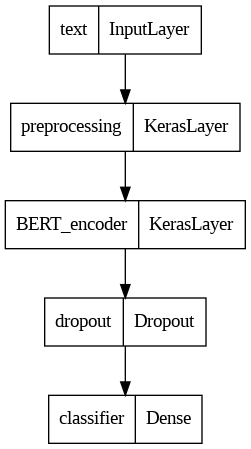

In [18]:
tf.keras.utils.plot_model(classifier_model)

## Model training

### Loss function

이것은 이진 분류 문제이고 모델이 확률을 출력하므로 'losses.BinaryCrossentropy' 손실 함수를 사용합니다.


In [19]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

미세 조정을 위해 BERT가 원래 훈련된 것과 동일한 최적화 프로그램인 "Adaptive Moments"(Adam)를 사용하겠습니다. 이 옵티마이저는 예측 손실을 최소화하고 [AdamW](https://arxiv.org/abs/1711.05101)라고도 하는 가중치 감쇠(모멘트를 사용하지 않음)로 정규화합니다.

학습률(`init_lr`)의 경우 BERT 사전 학습과 동일한 schedule을 사용합니다.

In [20]:
len(train_ds)

469

In [21]:
epochs = 5
steps_per_epoch = len(train_ds)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

훈련 시간은 선택한 BERT 모델의 복잡성에 따라 달라집니다. 작업시간 분 25분 소요.

In [22]:
import time
s = time.time()

print(f'Training model with {tfhub_handle_encoder}\n')
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3

Epoch 1/5
469/469 [==============================] - 487s 999ms/step - loss: 0.5412 - binary_accuracy: 0.7071 - val_loss: 0.4636 - val_binary_accuracy: 0.8034
Epoch 2/5
469/469 [==============================] - 471s 1s/step - loss: 0.3767 - binary_accuracy: 0.8240 - val_loss: 0.3919 - val_binary_accuracy: 0.8122
Epoch 3/5
469/469 [==============================] - 471s 1s/step - loss: 0.2645 - binary_accuracy: 0.8885 - val_loss: 0.5005 - val_binary_accuracy: 0.8178
Epoch 4/5
469/469 [==============================] - 471s 1s/step - loss: 0.1830 - binary_accuracy: 0.9269 - val_loss: 0.5905 - val_binary_accuracy: 0.8228
Epoch 5/5
469/469 [==============================] - 471s 1s/step - loss: 0.1312 - binary_accuracy: 0.9499 - val_loss: 0.6957 - val_binary_accuracy: 0.8204


In [23]:
print("총 소요 시간 {:.2f} 분".format((time.time() - s)/60))

총 소요 시간 39.53 분


### Evaluate the model


In [24]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

157/157 [==============================] - 48s 306ms/step - loss: 0.6957 - binary_accuracy: 0.8204
Loss: 0.695655107498169
Accuracy: 0.8203999996185303


### Plot the accuracy and loss over time

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


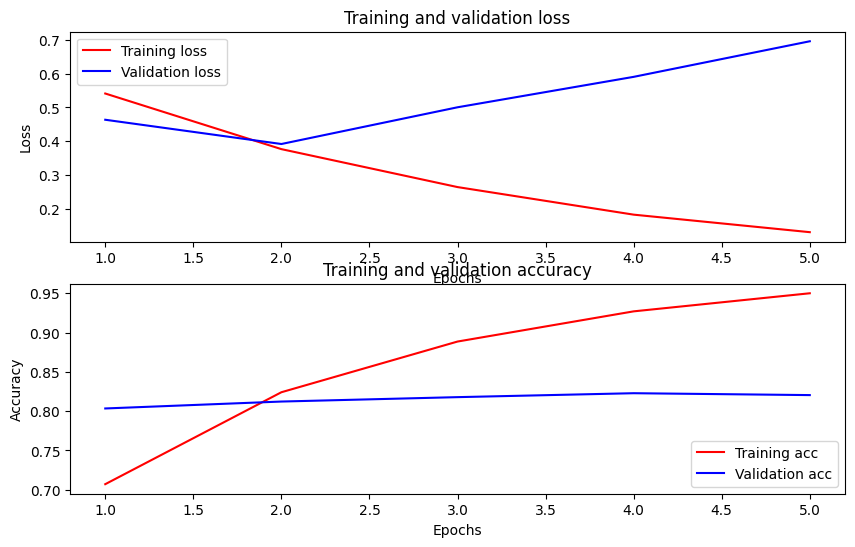

In [25]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export for inference

### Fine-tuning 한 모델 저장

In [26]:
dataset_name = 'kor_movie'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

### 저장한 모델 reload

In [27]:
reloaded_model = tf.saved_model.load(saved_model_path)

원하는 문장으로 모델을 테스트할 수 있습니다. 아래의 예제 변수에 추가하기만 하면 됩니다.

In [28]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

examples = [
     text_test[0],
    '이것은 놀라운 영화입니다!',
    '영화는 너무 훌륭했다!',
    '영화는 밋밋했다.',
    '영화는 재미있었다.',
    '영화는 끔찍했다...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
print_my_examples(examples, reloaded_results)

input: 여태까지 영화관에서 본영화중에 제일 재미있었음.     : score: 0.998511
input: 이것은 놀라운 영화입니다!                 : score: 0.981502
input: 영화는 너무 훌륭했다!                   : score: 0.990260
input: 영화는 밋밋했다.                      : score: 0.000920
input: 영화는 재미있었다.                     : score: 0.936638
input: 영화는 끔찍했다...                    : score: 0.000935



## Next steps

Naver movie review의 29만개 전체 dataset 사용하여 Fine Tuning